In [1]:
import sys
import os
import json

import numpy as np

sys.path.insert(0, os.path.abspath(".."))

import AetheriaPackage.ISA_tool as ISA
import AetheriaPackage.GeneralConstants as const
from AetheriaPackage.structures import calc_fuselage_weight as old_calc_fuselage_weight

d:\OneDrive - Delft University of Technology\Honours\02 Python\Honours Project\AetheriaPackage\AetheriaPackage\GeneralConstants.py:83: UserWarning: Missing nacelles data/counteracting effect for our design
  warn("Missing nacelles data/counteracting effect for our design")


In [2]:
file_path = r'C:\Users\Alfon\OneDrive - Delft University of Technology\Honours\02 Python\Honours Project\AetheriaPackage\output\_beta_sensitivity_3\run_optimizaton_b=0.510_Jun-01_22.03\design_state_b=0.510_Jun-01_22.03.json'

with open(file_path, 'r') as f:
    d = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Alfon\\OneDrive - Delft University of Technology\\Honours\\02 Python\\Honours Project\\AetheriaPackage\\output\\_beta_sensitivity_3\\run_optimizaton_b=0.510_Jun-01_22.03\\design_state_b=0.510_Jun-01_22.03.json'

### Testing Fix of TAS -> EAS in Fuselage C2WE

In [ ]:
cruise = ISA.ISA(const.h_cruise)
sea_level = ISA.ISA(0)

V_EAS = const.v_cr*np.sqrt(cruise.density()/sea_level.density())
V_EAS, const.v_cr

In [ ]:
d['Fuselage']['fuselage_weight']

In [ ]:
old_calc_fuselage_weight(mtom=d['AircraftParameters']['MTOM'],
                     lf=d['Fuselage']['length_fuselage'],
                     nult=d['AircraftParameters']['n_ult'],
                     wf=d['Fuselage']['width_fuselage_outer'],
                     hf=d['Fuselage']['height_fuselage_outer'],
                     v_cr=const.v_cr,
                     rho_cr=const.rho_cr,
                     rho_sl=const.rho_sl
                     )

## Modeling Surface Area of Aetheria

In [1]:
import sys
import os

import numpy as np
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib widget

sys.path.insert(0, os.path.abspath(".."))

from AetheriaPackage.basic_functions import Linear
import AetheriaPackage.tail_plotter_tools as tpt

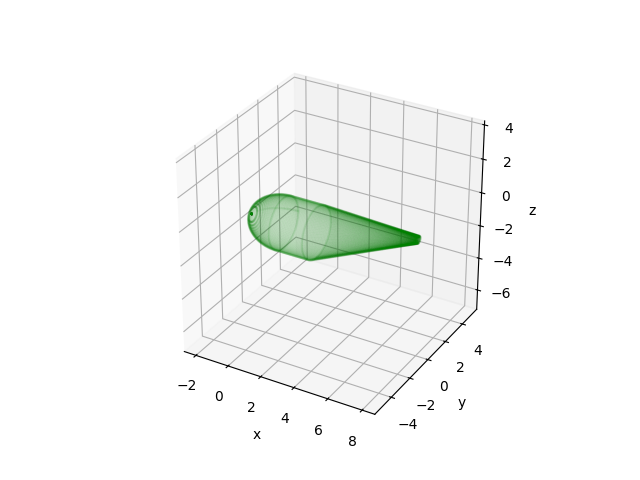

69.4785569216035

In [2]:
def calc_fuselage_wetsurface(D_fus:float, l_fuse:float, l_nose:float, 
                     l_tail:float, D_end:float, plot:bool=False,
                     **style):
    '''Function to calculate the wetted area of the fuselage.
    
    The implemented models breaks the fuselage into the following three components:
    1. Nosecone, as half of a 3D ellipsoid
    2. Tailcone, as a sheared/skewed frustrum
    3. Cylindrical part of fuselage.
    
    Throughout the function, the following abbreviations are used:
    nc       : nosecone
    tc       : tailcone
    fuse     : fuselage
    fun      : function
    fun_diff : derivative function

    The coordinate system is changed for the integration of each component, this makes
    reference to x, y, z different between components.

    Parameters
    ----------
    D_fus: FLOAT [m]
        Maximum diameter of fuselage.
    l_fuse: FLOAT [m]
        Length of fuselage
    l_nose: FLOAT [m]
        Length of nosecone. 
    l_tail: FLOAT [m]
        Length of tailcone.
    D_end: FLOAT [m]
        Maximum cross-section length at the end of the tail.
    plot: BOOL (default: FALSE)
        Specify whether to plot the fuselage in 3D.
    
    Returns
    -------
    S : FLOAT [m2]
        Wetted area of the fusealge.
    '''
    # Define constants for the rest of the module.
    R0 = D_fus/2
    Rf = D_end/2
    l_cyl = l_fuse-l_tail-l_nose

    # Initialise plotting, if needed.
    if plot:
        ax = plt.figure().add_subplot(projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    
    # 1. NOSECONE
    ### ------------------------------------------------------------
    # Define the radius function (ellipse)
    rho_fun      = lambda z: R0*np.sqrt(1-z**2/l_nose**2)
    rho_fun_diff = lambda z: R0*(1/2)*(1-z**2/l_nose**2)**(-1/2)*(-2*z/l_nose**2)

    # Defining the surface, as a parametrization of theta, z
    r_nc    = lambda theta, z : np.array([rho_fun(z)*np.cos(theta),
                                        rho_fun(z)*np.sin(theta), 
                                        z                        ]) 

    # Derivative of r_nc w.r.t. theta
    r_nc_theta = lambda theta, z : np.array([-rho_fun(z)*np.sin(theta), 
                                            rho_fun(z)*np.cos(theta) , 
                                            np.zeros(np.shape(z))     ])

    # Derivative of r_nc w.r.t. z
    r_nc_z     = lambda theta, z : np.array([rho_fun_diff(z)*np.cos(theta), 
                                            rho_fun_diff(z)*np.sin(theta), 
                                            np.ones(np.shape(z))])

    # Defining the integrand
    nosecone_surface_integrand = lambda theta, z: np.linalg.norm(np.cross(r_nc_theta(theta, z), r_nc_z(theta, z)))

    # integrate
    S_nc = sp.integrate.dblquad(nosecone_surface_integrand, 0, l_nose, 0, 2*np.pi)[0]

    if plot:
        # plot the surface
        z_lst = np.linspace(0, l_nose, 25)
        t_lst = np.linspace(0, 2*np.pi, 100)

        zz, tt = np.meshgrid(z_lst, t_lst)

        xx, yy, zz = r_nc(tt, zz)

        ax.scatter(-zz, xx, -yy-R0, s=1,**style)

    # 2. TAILCONE
    ### ------------------------------------------------------------

    # Define radius of the cone as function of the length along the tail.
    rho_fun = Linear(0, l_tail, R0, Rf)
    # Define deviation of the centre of the circle as function of length
    # along the tail
    eps_fun = Linear(0, l_tail, 0, (R0-Rf))

    # Defining the surface as a parametrization of theta, z
    r_tc    = lambda theta, z : np.array([rho_fun(z)*np.sin(theta)                , 
                                        R0 - eps_fun(z) + rho_fun(z)*np.cos(theta), 
                                        z                                          ]) 

    # Derivative of r_tc w.r.t. theta
    r_tc_theta = lambda theta, z : np.array([rho_fun(z)*np.cos(theta) , 
                                            -rho_fun(z)*np.sin(theta), 
                                            np.zeros(np.shape(z))     ])

    # Derivative of r_tc w.r.t. z
    r_tc_z     = lambda theta, z : np.array([rho_fun.diff(z)*np.sin(theta), 
                                             -eps_fun.diff(z)+rho_fun.diff(z)*np.cos(theta), 
                                             np.ones(np.shape(z))])

    # Defining the integrand
    tailcone_surface_integrand = lambda theta, z: np.linalg.norm(np.cross(r_tc_theta(theta, z), r_tc_z(theta, z)))

    # integrate
    S_tl = sp.integrate.dblquad(tailcone_surface_integrand, 0, l_tail, 0, 2*np.pi)[0]

    # account for cap a the end of the tail
    S_tl += np.pi*Rf**2

    if plot:
        # plot the surface
        z_lst = np.linspace(0, l_tail, 80)
        t_lst = np.linspace(0, 2*np.pi, 100)

        zz, tt = np.meshgrid(z_lst, t_lst)

        xx, yy, zz = r_tc(tt, zz)

        ax.scatter(zz+l_cyl, xx, -yy, s=1, **style)

    # 3. Cylindrical part of Fuselage
    ### ------------------------------------------------------------
    S_cyl = 2*np.pi*R0*l_cyl

    if plot:
        tpt.plot_cylinder(ax, R0, l_cyl, 0, 0, -R0, caps=False, n=100, **style)

        tpt.set_axes_equal(ax)
        plt.show()

    # ALL. Putting Everything Together
    ### ------------------------------------------------------------

    # Calculate total surface
    S = S_nc + S_tl + S_cyl

    return S

calc_fuselage_wetsurface(3, 10, 2, 6, 0.4, plot=True, alpha=0.05, color='green')

## New C2WE Fuselage


<div>
<img src=".images/slide 9 meeting 06 10.png" width="800"/>
</div>

In [ ]:
# The present C2WE for the fuselage is shown below

def calc_fuselage_weight(mtom:float, lf:float, nult:float, wf:float, 
                         hf:float, v_cr:float, rho_cr:float, rho_sl:float) -> float:
    """ Returns mass of fuselage subsystem, using USAF method. 
    See Eq 5.25 (pg 76) Pt 5. Component Weight Estimation (Roskam).

    :param mtom: Maximum take off mass (Kg)
    :type mtom: float
    :param lf: Fuselage length (m)
    :type lf: float
    :param nult: Ultimate load factor (-)
    :type nult: float
    :param wf: Maximum fuselage width (m)
    :type wf: float
    :param hf: Maximum fuselage height (m)
    :type hf: float
    :param v_cr: design cruise speed  (m/s)
    :type v_cr: float
    :param rho_cr: density at cruise altitude (Kg/m3)
    :type rho_cr: float
    :param rho_sl: density at sea-level altitude (Kg/m3)
    :type rho_sl: float

    # THE FOLLOWING IS FOR CESSNA METHOD, WHICH IS NOT USED
    # :param max_per:  Maximium perimeter of the fuselage
    # :type max_per: float
    # :param npax: Amount of passengers including pilot
    # :type npax: int
    """

    # Convert to Imperial Units
    mtow_lbs = 2.20462 * mtom
    lf_ft = lf*3.28084
    nult = nult # ultimate load factor
    wf_ft = wf*3.28084 # width fuselage [ft]
    hf_ft = hf*3.28084 # height fuselage [ft]
    Vc_kts = v_cr*(rho_cr/rho_sl)**0.5*1.94384449 # design cruise speed [kts] (convert TAS -> EAS)

    fweigh_USAF = 200*((mtow_lbs*nult/10**5)**0.286*(lf_ft/10)**0.857*((wf_ft+hf_ft)/10)*(Vc_kts/100)**0.338)**1.1
    return fweigh_USAF*0.453592  

    #if identifier == "J1":
    #    # THIS IS CESSNA METHOD
    #    fweight_high = 14.86*(mtow_lbs**0.144)*((lf_ft/max_per_ft)**0.778)*(lf_ft**0.383)*(npax**0.455)
    #    mass = fweight_high*0.453592
    #else:
    #    fweight_high = 14.86*(mtow_lbs**0.144)*((lf_ft/max_per_ft)**0.778)*(lf_ft**0.383)*(npax**0.455)
    #    fweight_low = 0.04682*(mtow_lbs**0.692)*(max_per_ft**0.374)*(lf_ft**0.590)
    #    fweight = (fweight_high + fweight_low)/2
    #    mass = fweight*0.453592


### USAF 1 Fuselage

In [3]:
def calc_fuselage_weight_USAF1(mtom:float, lf:float, nult:float, wf:float, 
                         hf:float, v_cr:float, rho_cr:float, rho_sl:float) -> float:
    """ Returns mass of fuselage subsystem, using USAF method. 
    See Eq 5.25 (pg 76) Pt 5. Component Weight Estimation (Roskam).

    :param mtom: Maximum take off mass (Kg)
    :type mtom: float
    :param lf: Fuselage length (m)
    :type lf: float
    :param nult: Ultimate load factor (-)
    :type nult: float
    :param wf: Maximum fuselage width (m)
    :type wf: float
    :param hf: Maximum fuselage height (m)
    :type hf: float
    :param v_cr: Design cruise speed (TAS)  (m/s)
    :type v_cr: float
    :param rho_cr: Density at cruise altitude (Kg/m3)
    :type rho_cr: float
    :param rho_sl: Density at sea-level altitude (Kg/m3)
    :type rho_sl: float

    """

    # Convert to Imperial Units
    mtow_lbs = 2.20462 * mtom
    lf_ft    = 3.28084 * lf
    wf_ft    = 3.28084 * wf 
    hf_ft    = 3.28084 * hf  

    v_cr_kts = v_cr*(rho_cr/rho_sl)**0.5*1.94384449 # (convert TAS -> EAS)

    fweigh_USAF = 200*((mtow_lbs*nult/10**5)**0.286*(lf_ft/10)**0.857*((wf_ft+hf_ft)/10)*(v_cr_kts/100)**0.338)**1.1
    return fweigh_USAF*0.453592  


### USAF 2 Fuselage

In [4]:
def calc_fuselage_weight_USAF2(mtom:float, lf:float, lt:float, nult:float, wf:float, hf:float, wt:float, ht:float, 
                        v_cr:float, rho_cr:float, rho_sl:float) -> float:
    """ Returns mass of fuselage subsystem, using modified USAF method. 
    The idea is to account for various tail geometies, separating the fuselage 
    into two parts, and weighting the maximum height and width of the second part
    with the end-of-tail height and width.
    See Eq 5.25 (pg 76) Pt 5. Component Weight Estimation (Roskam).

    :param mtom: Maximum take off mass (Kg)
    :type mtom: float
    :param lf: Fuselage length (m)
    :type lf: float
    :param lt: Fuselage tail (m)
    :type lt: float
    :param nult: Ultimate load factor (-)
    :type nult: float
    :param wf: Maximum fuselage width (m)
    :type wf: float
    :param hf: Maximum fuselage height (m)
    :type hf: float
    :param wt: End-of-tail width (m)
    :type wt: float
    :param ht: End-of-tail height (m)
    :type ht: float
    :param v_cr: Design cruise speed (TAS)  (m/s)
    :type v_cr: float
    :param rho_cr: Density at cruise altitude (Kg/m3)
    :type rho_cr: float
    :param rho_sl: Density at sea-level altitude (Kg/m3)
    :type rho_sl: float

    """
    # Convert to Imperial Units
    mtow_lbs = 2.20462 * mtom
    lf_ft    = 3.28084 * lf
    lt_ft    = 3.28084 * lt
    wf_ft    = 3.28084 * wf 
    hf_ft    = 3.28084 * hf  
    wt_ft    = 3.28084 * wt  
    ht_ft    = 3.28084 * ht   
    v_cr_kts = v_cr*(rho_cr/rho_sl)**0.5*1.94384449 # (convert TAS -> EAS)

    # measure of fuselage size in first component
    m1 = wf_ft+hf_ft 
    
    # measure of fuselage size in second component
    a = 0.5
    m2 = (wf_ft+hf_ft)*a + (wt_ft+ht_ft)*(1-a)

    fweigh_1 = 200*((mtow_lbs*nult/10**5)**0.286*(lf_ft-lt_ft/10)**0.857*((m1)/10)*(v_cr_kts/100)**0.338)**1.1
    fweigh_2 = 200*((mtow_lbs*nult/10**5)**0.286*(lt_ft/10      )**0.857*((m2)/10)*(v_cr_kts/100)**0.338)**1.1
    print(fweigh_1, fweigh_2)
    return (fweigh_1+fweigh_2)*0.453592

### Raymer Method

In [5]:
def calc_fuselage_weight_Raymer(mtom:float, nult:float, l_fus:float, 
                               l_nose:float, l_tail:float, D_fus:float,
                               D_eot:float, cl_cr:float, cd_cr:float, 
                               rho_cr:float, V_cr:float) -> float:



    Sf = calc_fuselage_wetsurface(D_fus, l_fus, l_nose, l_tail, D_eot)
    q  = 0.5*rho_cr*V_cr**2

    # convert to imperial units
    Sf_ft    = 3.28084**2 * Sf
    mtom_lbs = 2.20462 * mtom
    lt_ft    = 3.28084 * l_tail
    q_lbft   = 0.020885434273039 * q

    w_fus = 0.052*(Sf_ft)**1.086*(nult*mtom_lbs)**0.177*(lt_ft)**(-0.051)*(cl_cr/cd_cr)**(-0.072)*q_lbft**0.241

    return w_fus*0.453592

## Comparing Methods

In [16]:
file_path  = r'..\output\_beta_sensitivity_4\run_optimizaton_b=0.520_Jun-09_13.53\design_state_b=0.520_Jun-09_13.53.json'
import time

from AetheriaPackage.data_structs import *
import AetheriaPackage.GeneralConstants as const

perf_par = AircraftParameters.load(file_path)
wing  =  Wing.load(file_path)
engine = Engine.load(file_path)
aero = Aero.load(file_path)
fuselage = Fuselage.load(file_path)

w_USAF1 = calc_fuselage_weight_USAF1(perf_par.MTOM, 
                                     fuselage.length_fuselage, 
                                     perf_par.n_ult, 
                                     fuselage.width_fuselage_outer, 
                                     fuselage.height_fuselage_outer, 
                                     const.v_cr,
                                     const.rho_cr,
                                     const.rho_sl)

# w_USAF2 = calc_fuselage_weight_USAF2(perf_par.MTOM,
#                                      fuselage.length_fuselage,
#                                      fuselage.length_tail,
#                                      perf_par.n_ult,
#                                      fuselage.width_fuselage_outer, 
#                                      fuselage.height_fuselage_outer,
#                                      fuselage.bf,
#                                      fuselage.hf,
#                                      const.v_cr,
#                                      const.rho_cr,
#                                      const.rho_sl                                     
#                                      )

w_RAY   = calc_fuselage_weight_Raymer(perf_par.MTOM,
                                      perf_par.n_ult,
                                      fuselage.length_fuselage,
                                      fuselage.length_cockpit,
                                      fuselage.length_tail,
                                      fuselage.diameter_fuselage,
                                      max(fuselage.bf, fuselage.hf),
                                      aero.cL_cruise,
                                      aero.cd_cruise,
                                      const.rho_cr,
                                      const.v_cr,
                                      )



fuselage.fuselage_weight, w_USAF1, w_RAY

(387.4880362667234, 387.48094507615593, 342.42543362205936)

In [19]:
# minimum difference between fuselage length and tail length
l_rest_min = fuselage.length_fuselage - fuselage.length_tail

In [22]:
l_fuse_lst = np.linspace(10, 20, 30)
l_tail_lst = np.linspace(6, 15, 30)

l_fuse_arr, l_tail_arr = np.meshgrid(l_fuse_lst, l_tail_lst)

shp = np.shape(l_fuse_arr)

w_USAF_arr = np.zeros(shp)
w_RAYM_arr = np.zeros(shp)

for idx in np.ndindex(shp):
    fuselage.length_tail     = l_tail_arr[idx]
    fuselage.length_fuselage = l_fuse_arr[idx]
    
    w_USAF_arr[idx] = calc_fuselage_weight_USAF1(perf_par.MTOM, 
                                     fuselage.length_fuselage, 
                                     perf_par.n_ult, 
                                     fuselage.width_fuselage_outer, 
                                     fuselage.height_fuselage_outer, 
                                     const.v_cr,
                                     const.rho_cr,
                                     const.rho_sl)

    w_RAYM_arr[idx] = calc_fuselage_weight_Raymer(perf_par.MTOM,
                                      perf_par.n_ult,
                                      fuselage.length_fuselage,
                                      fuselage.length_cockpit,
                                      fuselage.length_tail,
                                      fuselage.diameter_fuselage,
                                      max(fuselage.bf, fuselage.hf),
                                      aero.cL_cruise,
                                      aero.cd_cruise,
                                      const.rho_cr,
                                      const.v_cr,
                                      )
    

invalid_cond = (l_fuse_arr-l_tail_arr)<l_rest_min

w_USAF_arr[invalid_cond] = np.nan
w_RAYM_arr[invalid_cond] = np.nan

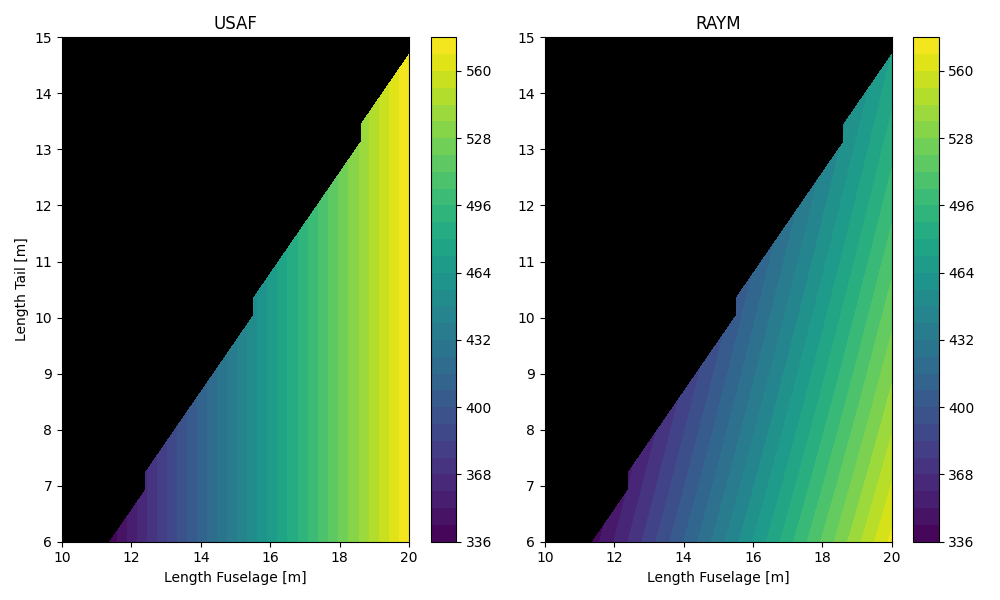

In [27]:
# USAF & RAYM side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
cntr1 = ax1.contourf(l_fuse_arr, l_tail_arr, w_USAF_arr,  levels=30)
fig.colorbar(cntr1, ax=ax1)
ax1.set_xlabel('Length Fuselage [m]')
ax1.set_ylabel('Length Tail [m]')
ax1.set_title('USAF')
ax1.set_facecolor("black")  

cntr2 = ax2.contourf(l_fuse_arr, l_tail_arr, w_RAYM_arr, levels=30)
fig.colorbar(cntr1, ax=ax2)
ax2.set_xlabel('Length Fuselage [m]')
ax2.set_title('RAYM')
ax2.set_facecolor("black")  

fig.tight_layout()

TypeError: Input z must be 2D, not 1D

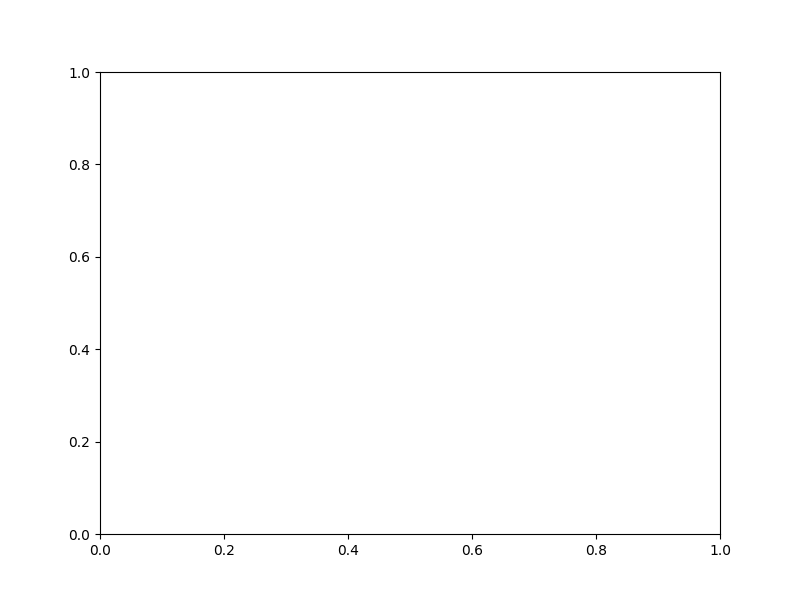

In [46]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8,6))
cntr1 = ax1.contourf(l_fuse_arr, l_tail_arr, w_RAYM_arr-w_USAF_arr, cmap='coolwarm',levels=30)
fig.colorbar(cntr1, ax=ax1)
ax1.set_ylabel('Length Tail [m]')
ax1.set_xlabel('Length Fuselage [m]')
ax1.set_title('RAYM-USAF')
ax1.set_facecolor("black") 

plt.savefig(r'.images/RAYM-USAF_2Dplot.svg')

In [33]:
l_fuse_lst = np.linspace(l_rest_min+0.1, 20, 100)
l_tail_lst = l_fuse_lst-l_rest_min

shp = np.shape(l_fuse_lst)

w_USAF_arr = np.zeros(shp)
w_RAYM_arr = np.zeros(shp)

for idx in np.ndindex(shp):
    fuselage.length_tail     = l_tail_lst[idx]
    fuselage.length_fuselage = l_fuse_lst[idx]
    
    w_USAF_arr[idx] = calc_fuselage_weight_USAF1(perf_par.MTOM, 
                                     fuselage.length_fuselage, 
                                     perf_par.n_ult, 
                                     fuselage.width_fuselage_outer, 
                                     fuselage.height_fuselage_outer, 
                                     const.v_cr,
                                     const.rho_cr,
                                     const.rho_sl)

    w_RAYM_arr[idx] = calc_fuselage_weight_Raymer(perf_par.MTOM,
                                      perf_par.n_ult,
                                      fuselage.length_fuselage,
                                      fuselage.length_cockpit,
                                      fuselage.length_tail,
                                      fuselage.diameter_fuselage,
                                      max(fuselage.bf, fuselage.hf),
                                      aero.cL_cruise,
                                      aero.cd_cruise,
                                      const.rho_cr,
                                      const.v_cr,
                                      )



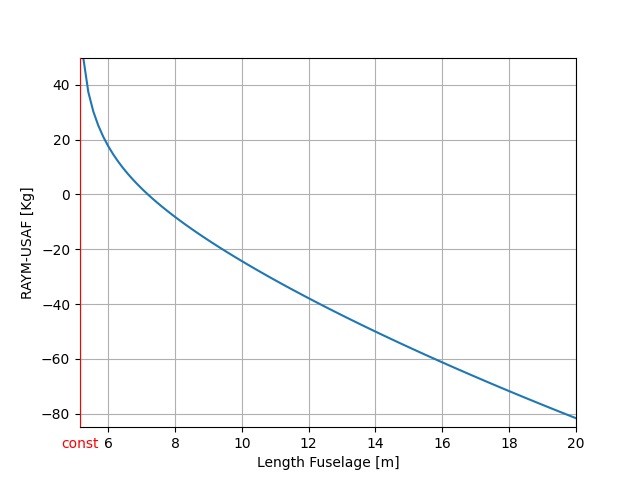

In [47]:
fig, ax = plt.subplots()
ax.plot(l_fuse_lst, w_RAYM_arr-w_USAF_arr)

ax.set_xlabel('Length Fuselage [m]')
ax.set_ylabel('RAYM-USAF [Kg]')

ax.vlines(l_rest_min, -90, 50, color='red', zorder=3)
ax.text( l_rest_min, -91, 'const', horizontalalignment='center', verticalalignment='center', color='red')

ax.grid()
ax.set_ylim(-85, 50)
ax.set_xlim(l_rest_min, 20)

plt.savefig(r'.images/RAYM-USAF_1Dplot.svg')
